In [8]:
from huggingface_hub import login

login("hf_XXX")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /home/artur/.cache/huggingface/token
Login successful


In [11]:
def read_text_file(file_path):
    with open(file_path, "r") as file:
        txt = file.read()
    return txt

# Function to generate a response for new messages
def generate_response(messages):
    inputs = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    outputs = model.generate(
        inputs,
        # attention_mask=inputs['attention_mask'],
        max_new_tokens=256,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
    )

    response = outputs[0][inputs.shape[-1]:]
    return tokenizer.decode(response, skip_special_tokens=True)

In [12]:
import json
import os

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

txts_folder = "ab_output"
for txt_file in os.listdir(txts_folder):
    file_path = os.path.join(txts_folder, txt_file)
    txt = read_text_file(file_path)
    print(f"Processing {txt_file}:")

    messages = [
        {
            "role": "system", "content": 
            '''
            Answer strictly in the form of a dictionary with the following keys:
            {
                "Location": "Helenental",
                "Description": "unerlaubte Rodung im Schutzgebiet",
                "Date": "April 1948",
                "Photographer": "Meisinger",
                "Film": "Neg.Nr. 3254/KIX/16, Film",
            }
            '''
        },
    ]
    new_message = {"role": "user", "content": txt}
    print(txt)
    messages.append(new_message)
    
    follow_up_response = generate_response(messages)
    print(follow_up_response)
    
    try:
        follow_up_response_dict = json.loads(follow_up_response)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        follow_up_response_dict = {"error": "Failed to decode response"}

    if not os.path.exists("llama_output"):
        os.makedirs("llama_output")
        
    json_file_path = os.path.join("llama_output", f"{os.path.splitext(txt_file)[0]}.json")
    with open(json_file_path, "w") as json_file:
        json.dump(follow_up_response_dict, json_file, ensure_ascii=False, indent=4)

/home/artur/tuwien/document_analysis/.venv/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/artur/tuwien/document_analysis/.venv/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/artur/tuwien/document_analysis/.venv/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
from openai import OpenAI


openai = OpenAI(
    api_key="V0C8fdR3vF63kgvOMfcefdDODGaWhXHf",
    base_url="https://api.deepinfra.com/v1/openai",
)

txts_folder = "ab_output"
for txt_file in os.listdir(txts_folder):
    file_path = os.path.join(txts_folder, txt_file)
    txt = read_text_file(file_path)
    print(f"Processing {txt_file}:")

    messages = [
        {
            "role": "system", "content": 
            '''
            Answer strictly in the form of a dictionary with the following keys:
            {
                "Location": "Helenental",
                "Description": "unerlaubte Rodung im Schutzgebiet",
                "Date": "April 1948",
                "Photographer": "Meisinger",
                "Film": "Neg.Nr. 3254/KIX/16, Film",
            }
            '''
        },
    ]
    
    new_message = {"role": "user", "content": txt}
    print(txt)
    messages.append(new_message)
    
    chat_completion = openai.chat.completions.create(
    model="meta-llama/Meta-Llama-3-70B-Instruct",
    messages=messages,
    )
    
    follow_up_response = chat_completion.choices[0].message.content
    print(follow_up_response)
    
    try:
        follow_up_response_dict = json.loads(follow_up_response.replace(',\n}', '\n}'))
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        follow_up_response_dict = {"error": "Failed to decode response"}

    if not os.path.exists("llama_output"):
        os.makedirs("llama_output")
        
    json_file_path = os.path.join("llama_output", f"{os.path.splitext(txt_file)[0]}.json")
    with open(json_file_path, "w") as json_file:
        json.dump(follow_up_response_dict, json_file, ensure_ascii=False, indent=4)

Processing 38.txt:
Hagenbachklamm
Aufn.Meisinger,April 1962.
Rollfilm 4x6,Neg.101/7 + 6



AuthenticationError: Error code: 401 - {'detail': 'User is not authorized to access this resource'}

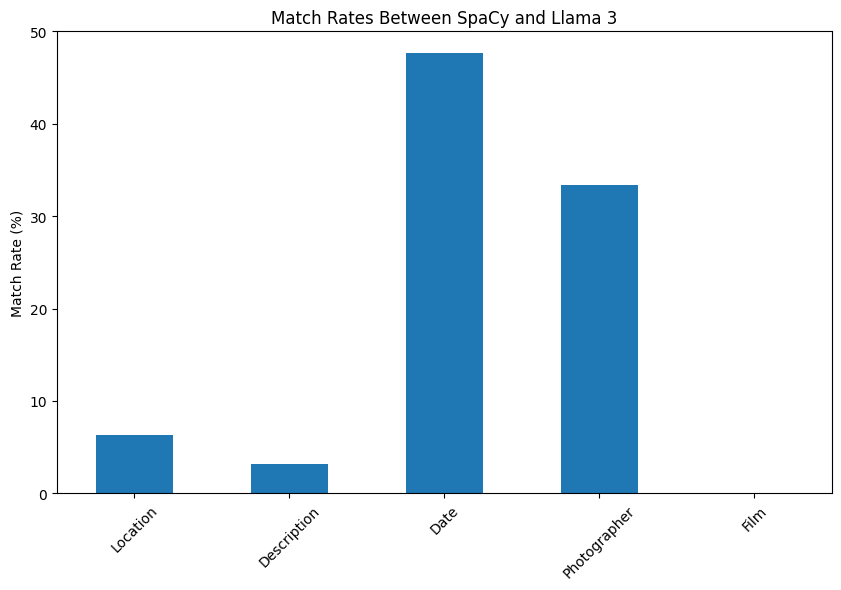

In [8]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

jsons_folder_spacy = "spacy_output"
jsons_folder_llama = "llama_output"

comparison_results = []

fields = ["Location", "Description", "Date", "Photographer", "Film"]

for json_file in os.listdir(jsons_folder_spacy):
    file_path_spacy = os.path.join(jsons_folder_spacy, json_file)
    file_path_llama = os.path.join(jsons_folder_llama, json_file)

    if os.path.exists(file_path_llama):
        with open(file_path_spacy, 'r') as file_spacy, open(file_path_llama, 'r') as file_llama:
            data_spacy = json.load(file_spacy)
            data_llama = json.load(file_llama)

            comparison = {"file": json_file}
            
            for field in fields:
                spacy_value = data_spacy.get(field, None)
                llama_value = data_llama.get(field, None)
                comparison[f"{field}_match"] = spacy_value == llama_value
                comparison[f"{field}_spacy_not_empty"] = spacy_value is not None and spacy_value != ""
                comparison[f"{field}_llama_not_empty"] = llama_value is not None and llama_value != ""

            comparison_results.append(comparison)

df_comparison = pd.DataFrame(comparison_results)

match_rates = df_comparison[[f"{field}_match" for field in fields]].mean() * 100
match_rates.plot(kind="bar", figsize=(10, 6), title="Match Rates Between SpaCy and Llama 3")
plt.ylabel("Match Rate (%)")
plt.xticks(range(len(fields)), fields, rotation=45)
plt.show()

       file  Location_wer  Location_spacy_not_empty  Location_llama_not_empty  \
0   62.json           NaN                     False                      True   
1   33.json      1.000000                      True                      True   
2   19.json      0.750000                      True                      True   
3   21.json           NaN                     False                      True   
4   42.json      0.500000                      True                      True   
..      ...           ...                       ...                       ...   
58  37.json           NaN                      True                     False   
59  22.json      0.333333                      True                      True   
60  16.json      0.666667                      True                      True   
61  13.json      2.000000                      True                      True   
62  35.json      2.000000                      True                      True   

    Description_wer  Descri

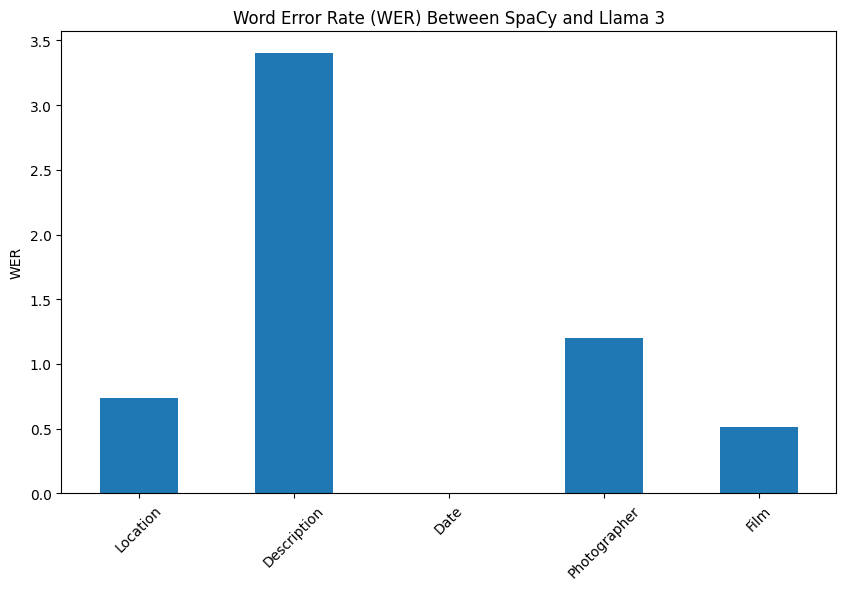

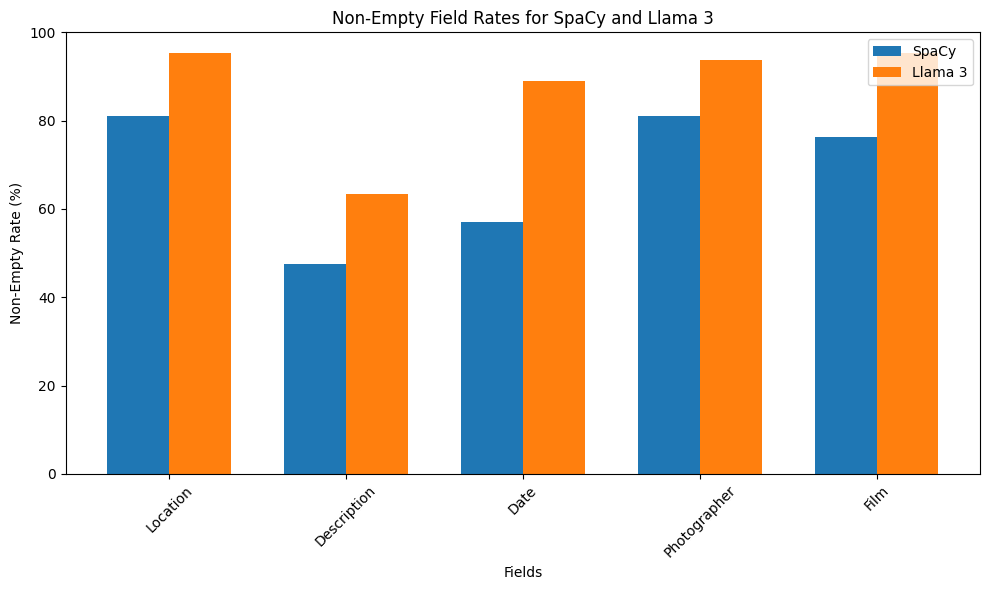

In [9]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from jiwer import wer

jsons_folder_spacy = "spacy_output"
jsons_folder_llama = "llama_output"

comparison_results = []


fields = ["Location", "Description", "Date", "Photographer", "Film"]

for json_file in os.listdir(jsons_folder_spacy):
    file_path_spacy = os.path.join(jsons_folder_spacy, json_file)
    file_path_llama = os.path.join(jsons_folder_llama, json_file)

    if os.path.exists(file_path_llama):
        with open(file_path_spacy, 'r') as file_spacy, open(file_path_llama, 'r') as file_llama:
            data_spacy = json.load(file_spacy)
            data_llama = json.load(file_llama)

            comparison = {"file": json_file}
            
            for field in fields:
                spacy_value = data_spacy.get(field, "")
                llama_value = data_llama.get(field, "")
                
                if spacy_value and llama_value:
                    comparison[f"{field}_wer"] = wer(spacy_value, llama_value)
                else:
                    comparison[f"{field}_wer"] = None  # Set WER to None if either value is empty
                
                comparison[f"{field}_spacy_not_empty"] = bool(spacy_value)
                comparison[f"{field}_llama_not_empty"] = bool(llama_value)

            comparison_results.append(comparison)

df_comparison = pd.DataFrame(comparison_results)
df_comparison.to_csv("comparison_results.csv", index=False)

print(df_comparison)

# Filter out None values from WER calculations
wer_means = df_comparison[[f"{field}_wer" for field in fields]].dropna().mean()
wer_means.plot(kind="bar", figsize=(10, 6), title="Word Error Rate (WER) Between SpaCy and Llama 3")
plt.ylabel("WER")
plt.xticks(range(len(fields)), fields, rotation=45)
plt.show()

# Plot non-empty field rates for SpaCy and Llama 3
spacy_not_empty_rates = df_comparison[[f"{field}_spacy_not_empty" for field in fields]].mean() * 100
llama_not_empty_rates = df_comparison[[f"{field}_llama_not_empty" for field in fields]].mean() * 100

fig, ax = plt.subplots(figsize=(10, 6))
index = range(len(fields))
bar_width = 0.35

bar1 = plt.bar(index, spacy_not_empty_rates, bar_width, label='SpaCy')
bar2 = plt.bar([i + bar_width for i in index], llama_not_empty_rates, bar_width, label='Llama 3')

plt.xlabel('Fields')
plt.ylabel('Non-Empty Rate (%)')
plt.title('Non-Empty Field Rates for SpaCy and Llama 3')
plt.xticks([i + bar_width / 2 for i in index], fields, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
